In [1]:
from ase.io import read
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path2dump = '/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/depth15/0deg_1000eV/dump.lammpstrj'
# atoms = read(path2dump, index=0, format='lammps-dump-text')

In [3]:
from ovito.io import import_file
from ovito.io.ase import ovito_to_ase

# Import a sequence of files.
pipeline = import_file(path2dump)

ase_atoms_list = []

# Loop over all frames of the sequence.
for frame_index in range(pipeline.source.num_frames):

    # Calling FileSource.compute() loads the requested frame
    # from the sequence into memory and returns the data as a new
    # DataCollection:
    data = pipeline.source.compute(frame_index)
    ase_atoms = ovito_to_ase(data)
    ase_atoms_list.append(ase_atoms)

    # The source path and the index of the current frame
    # are attached as attributes to the data collection:
    print('Frame source:', data.attributes['SourceFile'])
    print('Frame index:', data.attributes['SourceFrame'])
    break

/Users/y1u0d2/opt/anaconda3/envs/mlp/lib/python3.11/site-packages/ovito/_extensions/averaging.py:2: UserWarning: Did you accidentally install the OVITO package from the PyPI repository in an Anaconda/Miniconda Python interpreter using the 'pip' command? This will likely lead to conflicts with existing libraries in the Anaconda environment, and import of the OVITO module may fail with an error related to the Qt framework. To fix this, please uninstall the ovito pip package by running 'pip uninstall -y ovito PySide6' and then install the OVITO Anaconda package provided by OVITO GmbH. Visit https://docs.ovito.org/python/introduction/installation.html for further instructions. If you would rather like to ignore this warning message, add the following code to the top of your Python script:

  import warnings
  warnings.filterwarnings('ignore', message='.*OVITO.*PyPI')

  import ovito._extensions.pyscript


Frame source: /Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/depth15/0deg_1000eV/dump.lammpstrj
Frame index: 0


(0.0, 149.325)

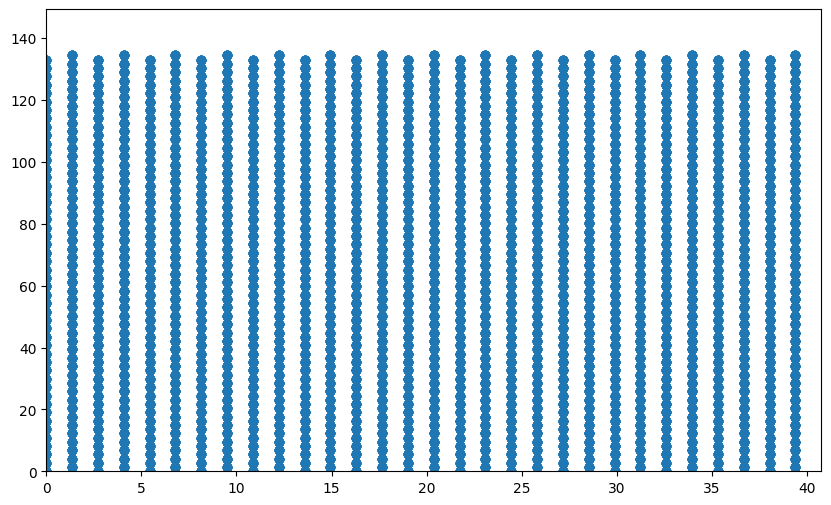

In [4]:
atoms = ase_atoms_list[0]
coord = atoms.get_positions()
cell = atoms.get_cell()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.scatter(coord[:, 0], coord[:, 2])
ax.set_xlim(0, cell[0].max())
ax.set_ylim(0, cell[2].max())

In [22]:
# extract atoms on the given range
x_range = [10, 20]
y_range = [20, 30]
z_range = [130, 149.325]

extracted_atoms = atoms[
    (atoms.positions[:, 0] > x_range[0]) & (atoms.positions[:, 0] < x_range[1]) &
    (atoms.positions[:, 1] > y_range[0]) & (atoms.positions[:, 1] < y_range[1]) &
    (atoms.positions[:, 2] > z_range[0]) & (atoms.positions[:, 2] < z_range[1])
]
extracted_atoms.set_positions(extracted_atoms.positions - np.array([x_range[0], y_range[0], z_range[0]]))
extracted_atoms.set_cell([
    [x_range[1] - x_range[0], 0, 0],
    [0, y_range[1] - y_range[0], 0],
    [0, 0, z_range[1] - z_range[0]]
])
extracted_atoms.wrap()
print(extracted_atoms.symbols)

H28


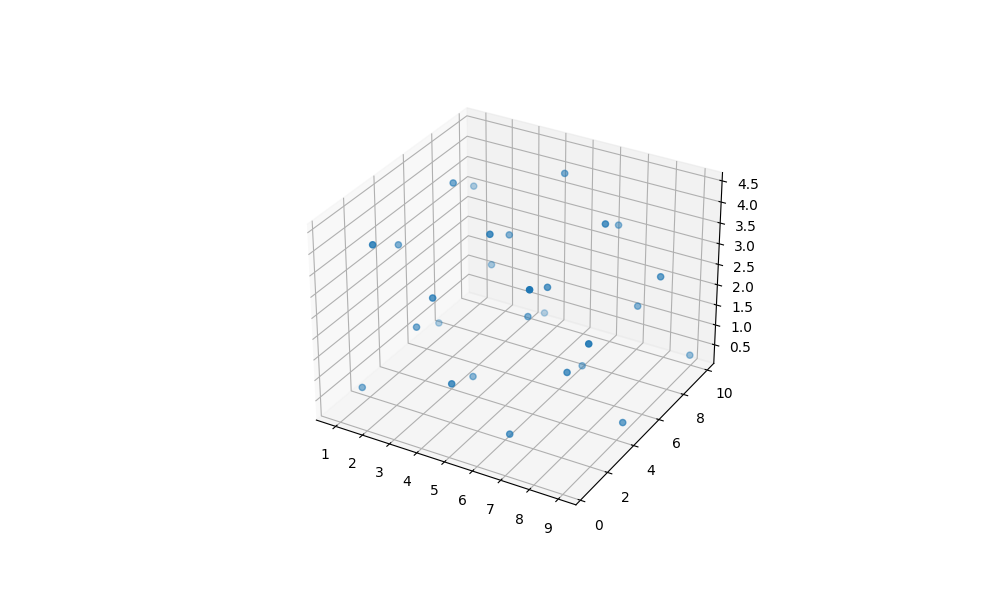

In [32]:
# plot atom 3D coordinates with interactivity
extracted_atoms_coord = extracted_atoms.get_positions()
extracted_atoms_cell = extracted_atoms.get_cell()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(extracted_atoms_coord[:, 0], extracted_atoms_coord[:, 1], extracted_atoms_coord[:, 2])


In [33]:
# get number of atoms
print(len(extracted_atoms))

28


In [34]:
from mlptools.atoms.extract_atoms import extract_atoms

extracted_atoms = extract_atoms(atoms, x_range, y_range, z_range)